# PIACC Inverter Example 

This notebook is a basic functional example of how to use PIACC to create a basic inverter from high level description, to netlist, to layout using the SKY130 process technology. 

# Checking imports

In [8]:
import os 
import PySpice.Spice.Simulation
import subprocess
import gdstk
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
from pathlib import Path

PySpice.Spice.Simulation.CircuitSimulator.DEFAULT_SIMULATOR = 'ngspice-shared'

ALIGN_PDK_DIR = './ALIGN-public/pdks/SKY130_PDK/'
ALIGN_NET_DIR = 'ALIGN_WORK_DIR/'

# Function Definition

In [14]:
#pyspice to align port 
def export_circuit_to_align(circuit, align_dir='ALIGN_WORK_DIR', cell_name='my_circuit'):
    """
    Exports a PySpice circuit to a SPICE netlist compatible with ALIGN.

    Parameters:
    - circuit: PySpice Circuit object
    - align_dir: str, path to ALIGN working directory
    - cell_name: str, name of the circuit (also used as subckt name and folder name)
    """
    #from PySpice.Spice.Netlist import Circuit

    if not isinstance(circuit, Circuit):
        raise ValueError("Expected a PySpice Circuit object.")

    # Create target directory
    cell_dir = Path(align_dir) / cell_name
    cell_dir.mkdir(parents=True, exist_ok=True)

    # Format the netlist string
    netlist_lines = str(circuit).splitlines()

    # Remove .include or .lib lines (ALIGN doesn't need models here)
    netlist_lines = [line for line in netlist_lines if not line.strip().lower().startswith(('.include', '.lib', '.param', '.control'))]

    # Ensure netlist is wrapped in a .subckt block if not already
    has_subckt = any(line.lower().startswith('.subckt') for line in netlist_lines)
    if not has_subckt:
        # Collect all nodes involved (rough heuristic)
        nodes = set()
        for line in netlist_lines:
            tokens = line.split()
            if tokens and tokens[0][0].upper() in 'MRCLX':
                nodes.update(tokens[1:-1])
        ports = ' '.join(sorted(nodes - {'vdd', 'vss', 'gnd'}))
        netlist_lines.insert(0, f'.subckt {cell_name} {ports}')
        netlist_lines.append(f'.ends {cell_name}')

    # Write to file
    netlist_path = cell_dir / f'{cell_name}.sp'
    with open(netlist_path, 'w') as f:
        f.write('\n'.join(netlist_lines))

    print(f" :) Netlist exported for ALIGN: {netlist_path}")


# Circuit Definition

In [5]:
circuit = Circuit('inverter_sky130') #title of netlist 
circuit.lib('pySpiceLibrary/skywater-pdk/libraries/sky130_fd_pr/latest/models/sky130.lib.spice', 'tt') #connecting to spice lib

circuit.M('1', 'out', 'Vin', 'vdd', 'vdd', model='sky130_fd_pr__nfet_01v8', w=1e-6, l=0.15e-6)
circuit.M('2', 'out', 'Vin', 'vss', 'vss', model='sky130_fd_pr__pfet_01v8', w=1e-6, l=0.15e-6)

print(circuit)

.title inverter_sky130
.lib /PIACC/pySpiceLibrary/skywater-pdk/libraries/sky130_fd_pr/latest/models/sky130.lib.spice tt
M1 out Vin vdd vdd sky130_fd_pr__nfet_01v8 l=1.5e-07 w=1e-06
M2 out Vin vss vss sky130_fd_pr__pfet_01v8 l=1.5e-07 w=1e-06



In [6]:
export_circuit_to_align(circuit, align_dir='ALIGN_WORK_DIR', cell_name='my_circuit')

✅ Netlist exported for ALIGN: ALIGN_WORK_DIR/my_circuit/my_circuit.sp


In [12]:
!schematic2layout.py './ALIGN_WORK_DIR/my_circuit/' -p '/ALIGN-public/pdks/SKY130_PDK/' -w 

align.main INFO : Reading netlist: /PIACC/ALIGN_WORK_DIR/my_circuit/my_circuit.sp subckt=MY_CIRCUIT, flat=0
align.compiler.compiler INFO : Starting topology identification...
align.compiler.compiler INFO : Power and ground nets not found. Power grid will not be constructed.
align.compiler.compiler INFO : Completed topology identification.
align.cell_fabric.drc ERROR : Found errors: DRC 2
align.cell_fabric.drc ERROR : Found errors: DRC 2
align.pnr.main INFO : Running Place & Route for MY_CIRCUIT
align.pnr.build_pnr_model INFO : Reading contraint json file MY_CIRCUIT.pnr.const.json
align.pnr.build_pnr_model INFO : Reading contraint json file INV_70158072.pnr.const.json
align.pnr.build_pnr_model INFO : Reading contraint json file MY_CIRCUIT.pnr.const.json
align.pnr.build_pnr_model INFO : Reading contraint json file INV_70158072.pnr.const.json
align.pnr.placer INFO : Starting bottom-up placement on INV_70158072 1
PnR.placer.SeqPair.SeqPair INFO : Enumerated search
PnR.placer.Placer.Placeme

# Output GDS should look like this

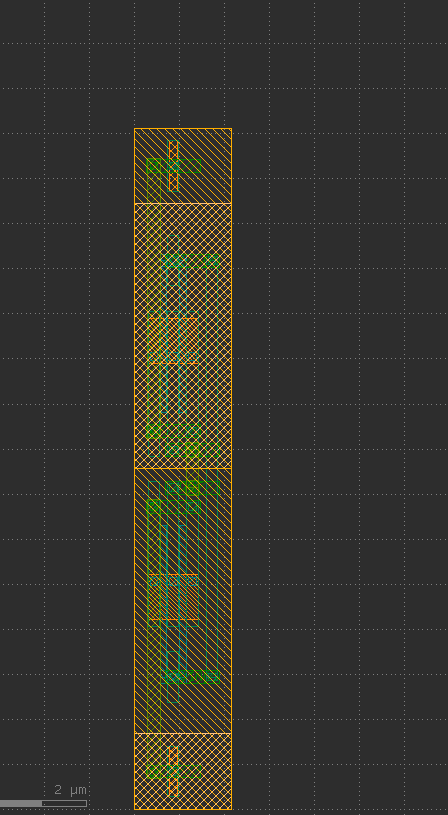

This will depend on what seed is used for the ALIGN generator. Many more customization options are available through ALIGN's scripts. It is recommended to use KLayout or another GDS viewer to interact with the gds files.